In [1]:
import os
import numpy as np
import pandas as pd
import torch
import model_before 

data_dir = "./csv_data"
file_name = "SampleData4.csv"

data = pd.read_csv(os.path.join(data_dir, file_name))

target_data = data.iloc[:, [3, 5]]
target_data.head()

,수출금액,수출중량
0,1246687,504237
1,1101985,463603
2,2430395,1108239
3,2264187,1073741
4,3574557,1632388


In [2]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(target_data)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [4]:
input_seq = 6
output_seq = 1
reframed = series_to_supervised(scaled, input_seq, output_seq)
reframed

,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
6,0.017063,0.098268,0.013651,0.086984,0.044978,0.265996,0.041058,0.256416,0.071960,0.411549,0.072812,0.419464,0.104970,0.577918
7,0.013651,0.086984,0.044978,0.265996,0.041058,0.256416,0.071960,0.411549,0.072812,0.419464,0.104970,0.577918,0.108999,0.594813
8,0.044978,0.265996,0.041058,0.256416,0.071960,0.411549,0.072812,0.419464,0.104970,0.577918,0.108999,0.594813,0.139393,0.739011
9,0.041058,0.256416,0.071960,0.411549,0.072812,0.419464,0.104970,0.577918,0.108999,0.594813,0.139393,0.739011,0.144860,0.770153
10,0.071960,0.411549,0.072812,0.419464,0.104970,0.577918,0.108999,0.594813,0.139393,0.739011,0.144860,0.770153,0.174815,0.900656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.796626,0.440986,0.810057,0.454264,0.118316,0.037617,0.112954,0.033133,0.278164,0.131302,0.238620,0.109424,0.420564,0.208400
185,0.810057,0.454264,0.118316,0.037617,0.112954,0.033133,0.278164,0.131302,0.238620,0.109424,0.420564,0.208400,0.389605,0.201081
186,0.118316,0.037617,0.112954,0.033133,0.278164,0.131302,0.238620,0.109424,0.420564,0.208400,0.389605,0.201081,0.544846,0.298420
187,0.112954,0.033133,0.278164,0.131302,0.238620,0.109424,0.420564,0.208400,0.389605,0.201081,0.544846,0.298420,0.506746,0.275379


In [5]:
var1_x = reframed.iloc[:, :2*input_seq:2]
var2_x = reframed.iloc[:, 1:2*input_seq:2]
var1_y = reframed.iloc[:, -2]
var2_y = reframed.iloc[:, -1]

data_x = np.stack([var1_x.values, var2_x.values],axis = 1)
data_x = torch.Tensor(data_x).permute(0, 2, 1)
data_y = np.stack([var1_y.values, var2_y.values],axis = 1)
data_y = torch.Tensor(data_y)

print(data_x.shape, data_y.shape)

torch.Size([183, 6, 2]) torch.Size([183, 2])


In [6]:
from torch.utils.data import TensorDataset
train_val_split = int(data_x.shape[0] * 0.8)
train_x, train_y = data_x[:train_val_split], data_y[:train_val_split]
val_x, val_y = data_x[train_val_split:], data_y[train_val_split:]


print("Train data shape : ",train_x.shape, train_y.shape)
print("Validation data shape : ",val_x.shape, val_y.shape)
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

Train data shape :  torch.Size([146, 6, 2]) torch.Size([146, 2])
Validation data shape :  torch.Size([37, 6, 2]) torch.Size([37, 2])


In [7]:
EPOCHS = 300 ####
output_len = 1
input_len = input_seq
input_dim = 2
hid_size = 1
num_stacks = 1
num_levels = 1
concat_len = 0
groups = 1
kernel = 5 ####
dropout = 0.5 #### 0.5가 best
lr = 1e-4
batch_size = 12 ####
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
model = model_before.SCINet(output_len = output_len, input_len= input_seq, input_dim = input_dim, hid_size = hid_size, num_stacks = num_stacks,
                num_levels = num_levels, concat_len = concat_len, groups = groups, kernel = kernel, dropout = dropout,
                 positionalE =  True).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [9]:
train_input, train_target = next(iter(train_loader))
train_target.shape

torch.Size([12, 2])

In [10]:
from tqdm import tqdm

train_loss_list = []
val_loss_list = []

for epoch in range(1, EPOCHS+1):

    for input, target in train_loader:
        input = input.to(device)
        target = target.to(device)
        model.train()
        optimizer.zero_grad()
        pred = model(input)
        loss = loss_function(pred, target)
        loss.backward()
        optimizer.step()
    
    print("Training")
    print("Epoch : {}, Loss : {}".format(epoch, loss.item()))    
    train_loss_list.append(loss.item())
    torch.cuda.empty_cache()
    for input, target in val_loader:
        input = input.to(device)
        target = target.to(device)
    with torch.no_grad():
        model.eval()
        pred = model(input)
        loss = loss_function(pred, target)
    print("Validation")
    print("Epoch : {}, Loss : {}".format(epoch, loss.item()))
    val_loss_list.append(loss.item())
    
    if epoch == 1:
        min_loss = val_loss_list[0]
        torch.save(model.state_dict(), './models/best.pt')
    else:
        if min_loss > val_loss_list[epoch - 1]:
            torch.save(model.state_dict(), './models/best.pt')
            min_loss = val_loss_list[epoch - 1]

/data/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([12, 2])) that is different to the input size (torch.Size([12, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2, 2])) that is different to the input size (torch.Size([2, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Training
Epoch : 1, Loss : 0.7532315254211426
Validation
Epoch : 1, Loss : 1.0975810289382935
Training
Epoch : 2, Loss : 0.8192402124404907
Validation
Epoch : 2, Loss : 1.0738797187805176
Training
Epoch : 3, Loss : 0.6929411292076111
Validation
Epoch : 3, Loss : 1.0505361557006836
Training
Epoch : 4, Loss : 1.018021821975708
Validation
Epoch : 4, Loss : 1.0280373096466064
Training
Epoch : 5, Loss : 0.8782976865768433
Validation
Epoch : 5, Loss : 1.0059666633605957
Training
Epoch : 6, Loss : 1.098836064338684
Validation
Epoch : 6, Loss : 0.9848082065582275
Training
Epoch : 7, Loss : 0.7128366827964783
Validation
Epoch : 7, Loss : 0.9640814065933228
Training
Epoch : 8, Loss : 0.9123715162277222
Validation
Epoch : 8, Loss : 0.9434226155281067
Training
Epoch : 9, Loss : 0.8048152923583984
Validation
Epoch : 9, Loss : 0.9234499931335449
Training
Epoch : 10, Loss : 0.9074889421463013
Validation
Epoch : 10, Loss : 0.9034563302993774
Training
Epoch : 11, Loss : 0.985791027545929
Validation
Epo

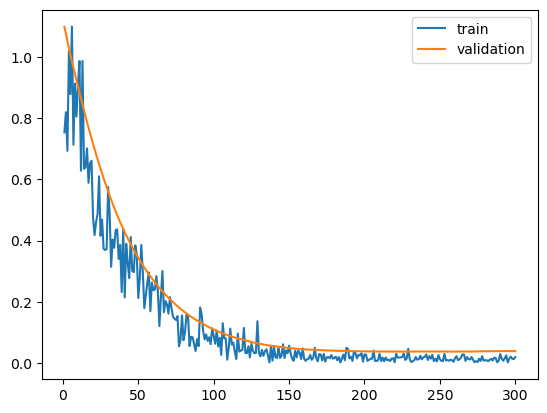

In [11]:
import matplotlib.pyplot as plt

epochs = np.arange(1, EPOCHS+1)
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, val_loss_list, label = 'validation')
plt.legend()
plt.show()